<a href="https://colab.research.google.com/github/kin0969/LendInvest/blob/master/Bad_loan_detection_w_o_region.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

!pip install category_encoders
import category_encoders as ce
import csv



     |████████████████████████████████| 102kB 2.1MB/s 


In [0]:
# Mount Google Drive for read and write
from google.colab import drive
drive.mount('/content/gdrive')
input_x_y_path="/content/gdrive/My Drive/Colab Notebooks/LendInvest/LogisticRegression/Raw Data/Input X and Y/"+"Train_X_Y_20200108_115344_only_cata_Enforcement.csv"
predict_x_test_path="/content/gdrive/My Drive/Colab Notebooks/LendInvest/LogisticRegression/Raw Data/Predict_X_test/"+"Predict_X_test_2019_09_24.csv"
predict_result_X_test_path="/content/gdrive/My Drive/Colab Notebooks/LendInvest/LogisticRegression/Result/"+"predict_result_X_test.csv"
general_result_path="/content/gdrive/My Drive/Colab Notebooks/LendInvest/LogisticRegression/Result/"


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
def _normalize_column_normal(X, train=True, specified_column = None, X_mean=None, X_std=None):
    # The output of the function will make the specified column number to 
    # become a Normal distribution
    # When processing testing data, we need to normalize by the value 
    # we used for processing training, so we must save the mean value and 
    # the variance of the training data
    if train:
        if specified_column == None:
            specified_column = np.arange(X.shape[1])
        length = len(specified_column)    
        X_mean = np.reshape(np.mean(X[:, specified_column],0), (1, length))
        X_std  = np.reshape(np.std(X[:, specified_column], 0), (1, length))

    X[:,specified_column] = np.divide(np.subtract(X[:,specified_column],X_mean), X_std)
    return X, X_mean, X_std

In [0]:
def _shuffle(X, Y):
    randomize = np.arange(len(X))
    np.random.shuffle(randomize)
    return X[randomize], Y[randomize]
    
def train_dev_split(X, y, dev_size=0.25):    
    train_len = int(round(len(X)*(1-dev_size)))
    return X[0:train_len,], y[0:train_len,], X[train_len:,], y[train_len:,]

In [0]:
def _sigmoid(z):
    # sigmoid function can be used to output probability
    return np.clip(1 / (1.0 + np.exp(-z)), 1e-6, 1-1e-6)

def _relu(z):
    # relu function can be used to output probability
    # return np.where(z < 0,  0, z)
    # Rewrite the Relu for no value less than 0 and greater than 1. Avoid math log error
     a=z
     a=np.where(z <= 0,  0.000001, a)
     a=np.where(a >= 1,  0.999999, a)
     return a



def _Leaky_relu(z):
    # Leaky relu function can be used to output probability
    return np.where(z < 0, z*0.2, z)

def get_pred_func_raw(X,w,b):        
#     return _sigmoid(np.add( X.dot(w) ,b))
    # return _Leaky_relu(np.add( X.dot(w) ,b))
    return _relu(np.add( X.dot(w) ,b))



def _gradient_regularization(X,Y_label,w,b,lambda_v):
    pred_func_raw = get_pred_func_raw(X, w, b)
    pred_error=Y_label-pred_func_raw
    w_grad=-(np.transpose(X).dot(pred_error))/pred_error.size+lambda_v*w
    b_grad=-np.mean(pred_error)    
    return w_grad, b_grad

In [0]:
def infer(X, w, b):
    # use round to infer the result
    return np.round(get_pred_func_raw(X, w, b))

def _cross_entropy(pred_func_raw, Y_label):
    # compute the cross entropy
    cross_entropy = -np.dot(Y_label, np.log(pred_func_raw))-np.dot((1-Y_label), np.log(1-pred_func_raw))
    return cross_entropy

def _loss(pred_func_raw, Y_label, lamda, w):
    return _cross_entropy(pred_func_raw, Y_label) + lamda * np.sum(np.square(w))

def accuracy(Y_pred, Y_label):
    acc = np.sum(Y_pred == Y_label)/len(Y_pred)
    return acc

In [0]:
def train(X_train, Y_train):    
#     dev_size=0.1155
    dev_size=0.0155
    max_iter=300   # number of full set cycle process    
    batch_size=10 # number of records to feed into Mini-Batch Gradient Descent
#     learning_rate=0.2 # how much the model learn for each step
    learning_rate=0.02 # how much the model learn for each step
    step=1  

    loss_train=[]  #Base on Cross entropy
    loss_dev=[]   #Base on Cross entropy
    acc_train=[]
    acc_dev=[]  
    
    # Split a test Set
    X_train, Y_train, X_dev, Y_dev=train_dev_split(X_train,Y_train,dev_size)
    
    num_train = len(Y_train)
    num_dev = len(Y_dev)
    
    # Using 0+0*x1+0*x2+...... for weight initialization
    w=np.zeros( (X_train.shape[1],))
    b=np.zeros((1))
    
    Regularization=True
    if (Regularization==True):
        lambda_v=0.001      
    else:
        lambda_v=0

    for epoch in range(max_iter):
        # Random shuffle for each epoch
        X_train, Y_train=_shuffle(X_train, Y_train)

        # Logistic Regression by Mini-Batch Gradient Descent
        for i in range(int(np.floor(Y_train.shape[0]/batch_size))):
            X=X_train[i*batch_size:(i+1)*batch_size,]
            Y=Y_train[i*batch_size:(i+1)*batch_size,]
        
            # Find out the Gradient
            w_grad, b_grad =_gradient_regularization(X, Y, w, b, lambda_v)

            # gradient descent update
            # learning rate decay with time
            w = w - learning_rate/np.sqrt(step) * w_grad
            b = b - learning_rate/np.sqrt(step) * b_grad

            step = step+1

        # Compute the loss and the accuracy of the training set and the validation set       
        y_train_pred_func_raw = get_pred_func_raw(X_train, w, b)
        Y_train_pred = np.round(y_train_pred_func_raw)
        
        acc_train.append(accuracy(Y_train_pred, Y_train))
        loss_train.append(_loss(y_train_pred_func_raw, Y_train, lambda_v, w)/num_train)
        
        y_dev_pred_func_raw = get_pred_func_raw(X_dev, w, b)
        Y_dev_pred = np.round(y_dev_pred_func_raw)
        acc_dev.append(accuracy(Y_dev_pred, Y_dev))
        loss_dev.append(_loss(y_dev_pred_func_raw, Y_dev, lambda_v, w)/num_dev)
    

    
    #Write File for detail comparison
    # Print Y_train,Y_train_pred,y_train_pred_func_raw     
    csv_f = open(general_result_path+"Y_Train_Detail_Comparison.csv","w")
    csv_w = csv.writer(csv_f)
    title = ['Y_train','Y_train_pred','y_train_pred_func_raw']
    csv_w.writerow(title) 
    # 291
    for i in range(Y_train.shape[0] ):
        content = [Y_train[i],Y_train_pred[i],y_train_pred_func_raw[i]]
        csv_w.writerow(content)
        
        
    # Print Y_dev,Y_dev_pred,y_dev_pred_func_raw     
    csv_f = open(general_result_path+"Y_DEV_Detail_Comparison.csv","w")
    csv_w = csv.writer(csv_f)
    title = ['Y_dev','Y_dev_pred','y_dev_pred_func_raw']
    csv_w.writerow(title) 
    # 291
    for i in range(Y_dev.shape[0] ):
        content = [Y_dev[i],Y_dev_pred[i],y_dev_pred_func_raw[i]]
        csv_w.writerow(content)
    
    return w, b, loss_train, loss_dev, acc_train, acc_dev  # return loss for plotting

In [0]:
# Read from Raw Data
raw_data=np.genfromtxt((input_x_y_path) ,delimiter=',') 
X_raw=raw_data[1:,2:8];
X_train = np.delete(X_raw, 3, 1)  # delete second column of C
Y_train=raw_data[1:,8];

# # Fill nan with 0
where_nas=np.isnan(X_train)
X_train[where_nas]=0

# Change numpy array type 
X_train = X_train.astype('float64') 
Y_train = Y_train.astype('float64') 

print (X_raw)
print (Y_train)

[[2.17413e+05 6.40000e+01 1.80000e+01         nan 6.50000e-02         nan]
 [3.42000e+05 7.00000e+01 1.00000e+01         nan 6.00000e-02         nan]
 [2.52000e+05 4.60000e+01 1.20000e+01         nan 4.00000e-02         nan]
 ...
 [1.90488e+05 4.40000e+01 1.20000e+01         nan 5.50000e-02         nan]
 [3.71516e+05 5.70000e+01 1.20000e+01         nan 7.00000e-02         nan]
 [3.13500e+05 7.00000e+01 1.20000e+01         nan 6.75000e-02         nan]]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

In [0]:
# These are the columns that I want to normalize
col = [0,1,2,3,4]

# X_train, Y_train=_shuffle(X_train, Y_train)
X_train, X_mean, X_std = _normalize_column_normal(X_train, specified_column=col)

# return loss is to plot the result
w, b, loss_train, loss_validation, acc_train, acc_test= train(X_train, Y_train)


 Loss_train 0.11113970449551633 


 Loss_validation 0.04276562629439636 



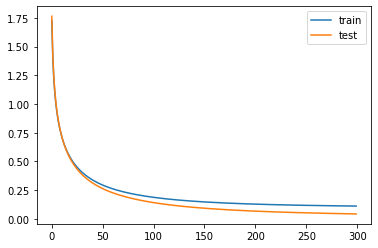

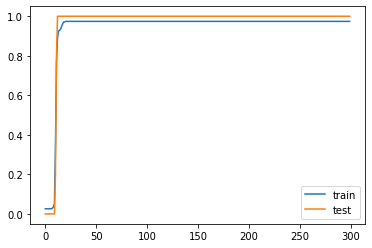

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

print ('\n Loss_train {0} \n'.format(loss_train[-1]) )
print ('\n Loss_validation {0} \n'.format(loss_validation[-1]) )

plt.plot(loss_train)
plt.plot(loss_validation)
plt.legend(['train', 'test'])
plt.show()

plt.plot(acc_train)
plt.plot(acc_test)
plt.legend(['train', 'test'])
plt.show()

In [0]:
# print (np.argsort(np.abs(w), axis=0) ) #按列排序

ind = np.argsort(np.abs(w))[::-1]
# with open("../input/Result_20190919_160221.csv") as f:
#     content = f.readline().rstrip('\n')
features = np.array(['LoanAmount','LTV','OriginalTerm','TrancheARate','TrancheBRate'])
for i in ind[0:10]:
    
    print(i,features[i], w[i])

4 TrancheBRate -0.02985995612884101
2 OriginalTerm 0.020588606464808732
1 LTV 0.011220677889129796
3 TrancheARate -0.005061428872226548
0 LoanAmount 0.0022814510683530362


In [0]:
 # Read from Raw Test Data
# Just for LoanID output
X_test_LoanID=np.genfromtxt((predict_x_test_path) ,delimiter=',',dtype="U75") 
    
X_test_data=np.genfromtxt((predict_x_test_path) ,delimiter=',') 
X_test_raw=X_test_data[1:,2:8];
X_test = np.delete(X_test_raw, 3, 1)  # delete second column of C


# # Fill nan with 0
where_nas=np.isnan(X_test)
X_test[where_nas]=0

# Change numpy array type 
X_test = X_test.astype('float64') 
print (X_test)


# Doing the same normalization as X_train
X_test, _, _= _normalize_column_normal(X_test, train=False, specified_column = col, X_mean=X_mean, X_std=X_std)

result_label =infer (X_test,w,b)
result_raw =get_pred_func_raw (X_test,w,b)

# Print Y_dev,Y_dev_pred,y_dev_pred_func_raw     
csv_f = open(predict_result_X_test_path,"w")
csv_w = csv.writer(csv_f)
title = ['LoanID','Result_label','Result_raw']
csv_w.writerow(title) 
for i in range(X_test.shape[0] ):
    content = [X_test_LoanID[i+1,1],result_label[i],result_raw[i]]
    csv_w.writerow(content)

[[7.0000e+06 7.0000e+01 1.8000e+01 7.0000e-02 0.0000e+00]
 [4.1250e+05 7.4320e+01 1.2000e+01 5.2500e-02 0.0000e+00]
 [1.5375e+05 7.5000e+01 1.2000e+01 5.2500e-02 0.0000e+00]
 [1.8715e+05 3.4020e+01 9.5000e+00 4.0000e-02 0.0000e+00]]


In [0]:
file_id = "1Llp483f91dAJriuE6PanmecLA9sWDPyi" # replace with your ID
!gdown https://drive.google.com/uc?id={file_id}

!ls

Downloading...
From: https://drive.google.com/uc?id=1Llp483f91dAJriuE6PanmecLA9sWDPyi
To: /content/iris.csv
100% 2.41k/2.41k [00:00<00:00, 3.56MB/s]
gdrive	iris.csv  sample_data


In [0]:
!ls /content/gdrive/My\ Drive/Colab\ Notebooks

# /content/gdrive/My Drive/Colab Notebooks/Result/"+"predict_result_X_test.csv"



LendInvest
